In [101]:
"""import the required libraries"""
import numpy as np 
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import math
from scipy.stats import multivariate_normal

In [102]:
"""read the data and preprocess it"""
input_data = open("/Users/kavinarasu/Desktop/GMM_dataset.txt", "r")
ipdata = input_data.read().splitlines()
new_data = [x.split("  ") for x in ipdata] 
new_data = np.asarray(new_data)
new_data = np.delete(new_data,0,1)
new_data = new_data.astype(float)
data=new_data

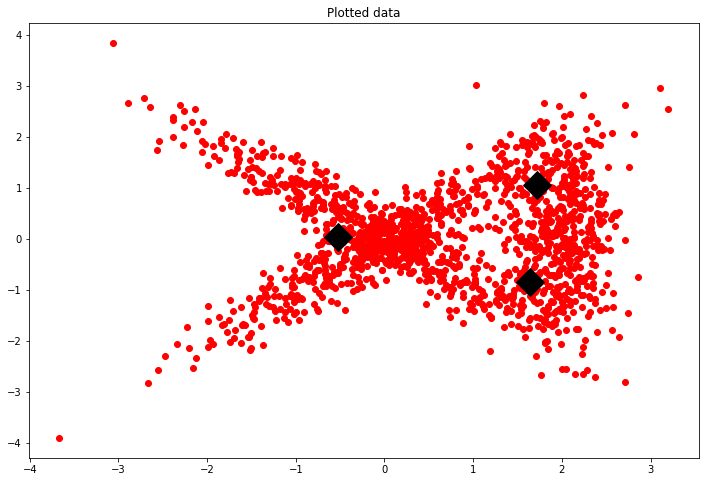

In [103]:
"""initialization step"""
#centroids taken from output of K-MEANS
mean =np.asfarray([[1.64650399,-0.85083626],[-0.52016677,0.03882836],[1.724763,1.04927424]])
plt.plot(data[:,0],data[:,1],'ro')
l=plt.plot(mean[:,0],mean[:,1],'kD')
plt.setp(l,'markersize',20)
plt.title('Plotted data')
plt.rcParams['figure.figsize']=[12,8]

In [104]:
covar=np.zeros((3,2))
pi = np.full((3),0.33)
def covariance_func(data,mean):
    for i, item in enumerate(mean):
        for j, xi in enumerate(data):
            covar[i]=covar[i]+(xi-item)**2
        covar[i]=covar[i]/data.shape[0]

covariance_func(data,mean)

gamma=np.zeros((1500,3))

def gamma_func(data,mean,covar):
    for i, xi in enumerate(data):
        var0 = multivariate_normal.pdf(data[i],mean=mean[0], cov=covar[0])
        var1 = multivariate_normal.pdf(data[i],mean=mean[1], cov=covar[1])
        var2 = multivariate_normal.pdf(data[i],mean=mean[2], cov=covar[2])
        gamma[i,0]=(pi[0]*var0)/((pi[0]*var0)+(pi[1]*var1)+(pi[2]*var2))
        gamma[i,1]=(pi[1]*var1)/((pi[0]*var0)+(pi[1]*var1)+(pi[2]*var2))
        gamma[i,2]=(pi[2]*var2)/((pi[0]*var0)+(pi[1]*var1)+(pi[2]*var2))
            
gamma_func(data,mean,covar)
